# <font color="#114b98">Catégorisez automatiquement des questions</font>

## <font color="#114b98">Notebook d'analyse exploratoire</font>

**Stack Overflow** est un site célèbre de questions-réponses liées au développement informatique.

L'objectif de ce projet est de développer un système de **suggestion de tags** pour ce site. Celui-ci prendra la forme d’un algorithme de machine learning qui assignera automatiquement plusieurs tags pertinents à une question.

**Livrable** : Un notebook d’exploration comprenant une analyse univariée, une analyse multivariée, une réduction dimensionnelle et les différentes questions de recherche associées (non cleané, pour comprendre votre démarche).

## <font color="#114b98">Sommaire</font>
[1. Chargement des jeux de données](#section_1)

[2. Analyse univariée](#section_2)  

[3. Analyse multivariée](#section_3)  

[4. Nettoyage de la colonne 'Tags'](#section_4)  

[5. Nettoyage de la colonne 'Texte'](#section_5)  

## <font color="#114b98" id="section_1">1. Chargement des jeux de données</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
plt.rc('axes', titlesize=22) 
plt.rc('axes', labelsize=18) 
titleprops = {'fontsize':20}
textprops = {'fontsize':15}
plt.style.use('ggplot')

J'ai tout d'abord réalisé la requête SQL suivante sur "StackExchange Data Explorer" afin de récuperer les données.
https://data.stackexchange.com/stackoverflow/query/

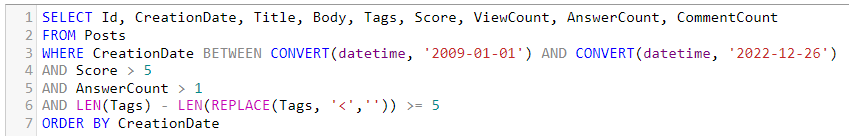

Je recevais 50000 réponses, ce qui est le maximum possible par requête sur ce site.

J'ai donc décidé de réaliser plusieurs requêtes avec des intervalles de temps de deux ans.

In [3]:
main_path = 'N:/5 - WORK/1 - Projets/Projet 5/'
files = os.listdir(main_path+'ressources/')
files

['QueryResults 01012009-31122010.csv',
 'QueryResults 01012011-31122012.csv',
 'QueryResults 01012013-31122014.csv',
 'QueryResults 01012015-31122016.csv',
 'QueryResults 01012017-31122018.csv',
 'QueryResults 01012019-31122020.csv',
 'QueryResults 01012021-26122022.csv']

Nous avons à notre disposition 7 jeux de données.

Je crée un dictionnaire dans lequel je range les noms des jeux de données en clefs et leurs contenus dans les valeurs.

In [4]:
%%time
datasets = {}
for i, filename in enumerate(files):
    datasets[i] = pd.read_csv(main_path+'ressources/'+filename, 
                              parse_dates=['CreationDate'],
                              na_values = 'NaN')

Wall time: 3.6 s


In [5]:
data = pd.DataFrame()

In [6]:
for n in range(len(datasets)):
    data = pd.concat([data, datasets[n]])

In [7]:
data.shape

(159599, 9)

In [8]:
data.head()

,Id,CreationDate,Title,Body,Tags,Score,ViewCount,AnswerCount,CommentCount
0,404421,2009-01-01 02:26:41,How do I get a scheme interpreter working insi...,<p>I'm going through SICP and I'd like to have...,<macos><emacs><scheme><interpreter><sicp>,16,9877,5,0
1,404899,2009-01-01 12:23:25,Scope of variables in a delegate,<p>I found the following rather strange. Then ...,<c#><functional-programming><delegates><lambda...,8,7989,6,0
2,404941,2009-01-01 13:25:37,"How can I pass an ""array"" of values to my stor...","<p>I want to be able to pass an ""array"" of val...",<mysql><database><arrays><postgresql><stored-p...,14,43638,7,0
3,405134,2009-01-01 16:45:13,Manually setting a UIButton state,<p>I <code>UIButton</code> using + <code>butto...,<ios><objective-c><iphone><cocoa-touch><uibutton>,20,47489,7,1
4,405359,2009-01-01 19:38:10,Should I check for DB constraints in code or s...,<p>I have an application that saves data into ...,<database><nhibernate><exception-handling><con...,20,3731,8,0


Je crée une nouvelle variable "Text" dans laquelle je joins les données des variables "Titre" et "Body".

In [9]:
data['Texte'] = data.apply(lambda x: x['Title'] + ' ' + x['Body'] if x['Title'] == x['Title'] else x['Body'], axis=1)

In [10]:
pd.set_option('display.max_column', 10)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159599 entries, 0 to 2669
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Id            159599 non-null  int64         
 1   CreationDate  159599 non-null  datetime64[ns]
 2   Title         159599 non-null  object        
 3   Body          159599 non-null  object        
 4   Tags          159599 non-null  object        
 5   Score         159599 non-null  int64         
 6   ViewCount     159599 non-null  int64         
 7   AnswerCount   159599 non-null  int64         
 8   CommentCount  159599 non-null  int64         
 9   Texte         159599 non-null  object        
dtypes: datetime64[ns](1), int64(5), object(4)
memory usage: 13.4+ MB


In [12]:
data.duplicated().sum()

0

In [13]:
data.isna().sum()

Id              0
CreationDate    0
Title           0
Body            0
Tags            0
Score           0
ViewCount       0
AnswerCount     0
CommentCount    0
Texte           0
dtype: int64

In [14]:
data.reset_index(inplace=True, drop=True)

## <font color="#114b98" id="section_2">2. Analyse univariée</font>

In [15]:
questions_per_day = data['CreationDate'].dt.date.value_counts()

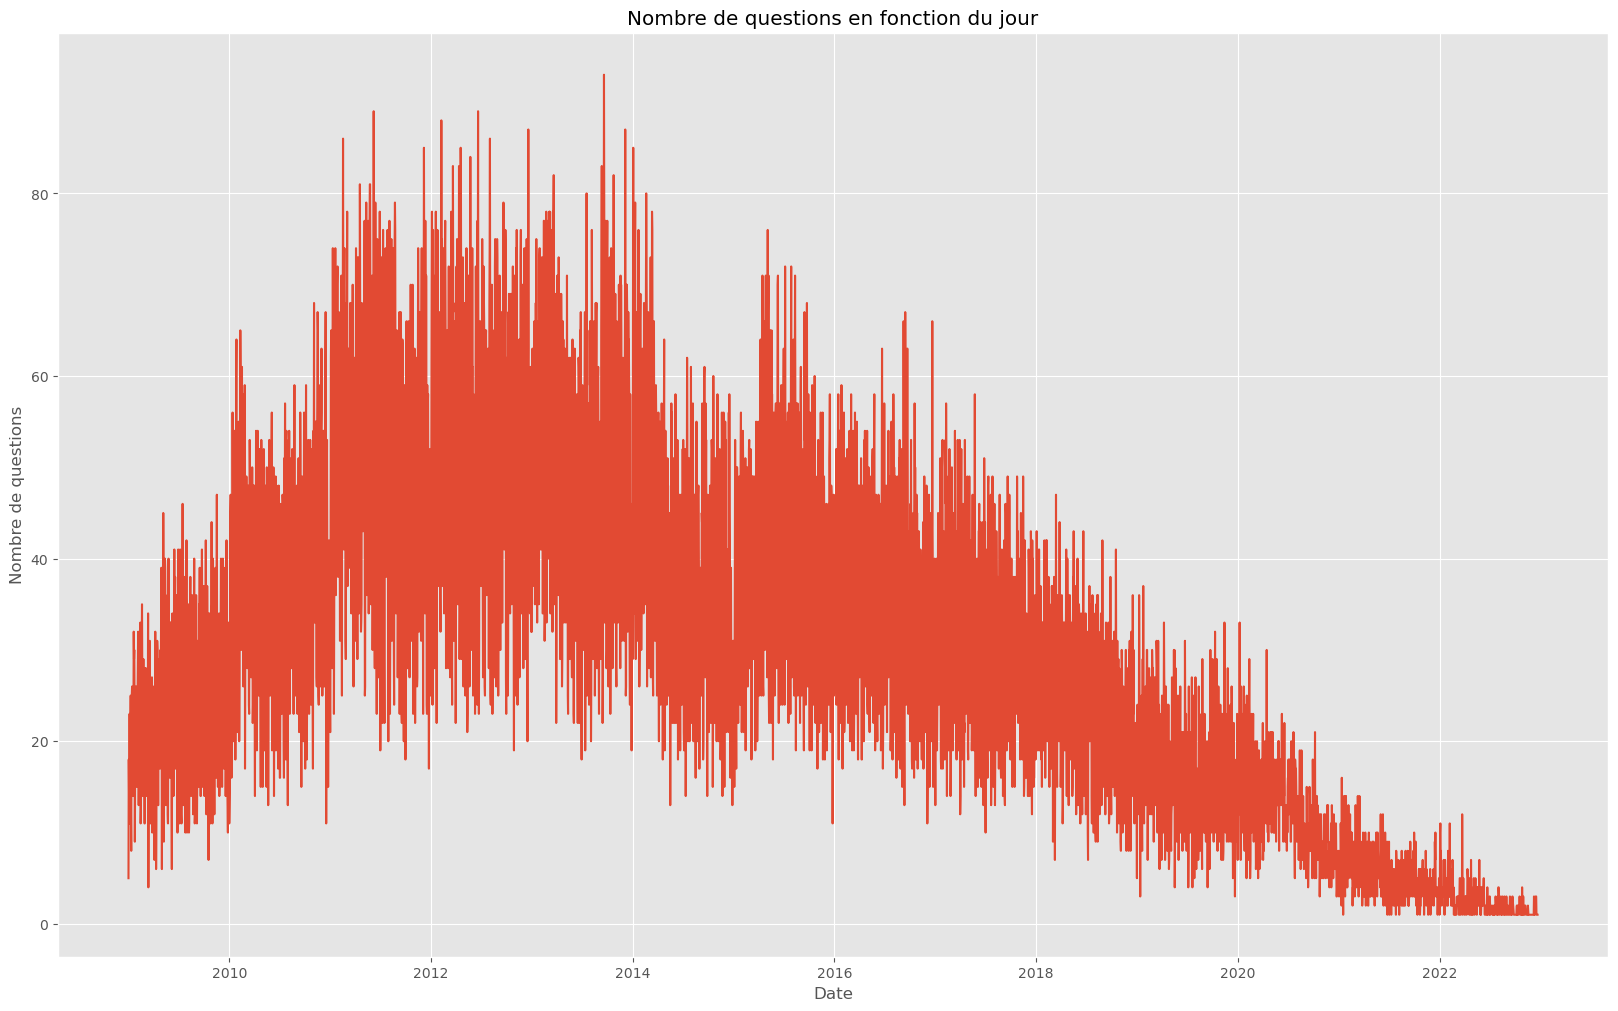

In [16]:
fig = plt.figure(figsize=(20, 12))
sns.lineplot(data=questions_per_day,
             x=questions_per_day.index,
             y=questions_per_day.values)
plt.xlabel("Date")
plt.ylabel("Nombre de questions")
plt.title("Nombre de questions en fonction du jour")

plt.show()

La tendance globale à la baisse est logique. Je me suis limité aux questions qui ont des réponses et un bon score. 

Plus une question est ancienne, plus elle a eu le temps d'être lue, commentée, et de recevoir un score positif si elle le mérite.

In [17]:
data["CreationDate_year"] = data["CreationDate"].map(lambda y: y.year)

In [18]:
questions_per_year = data["CreationDate_year"].value_counts()

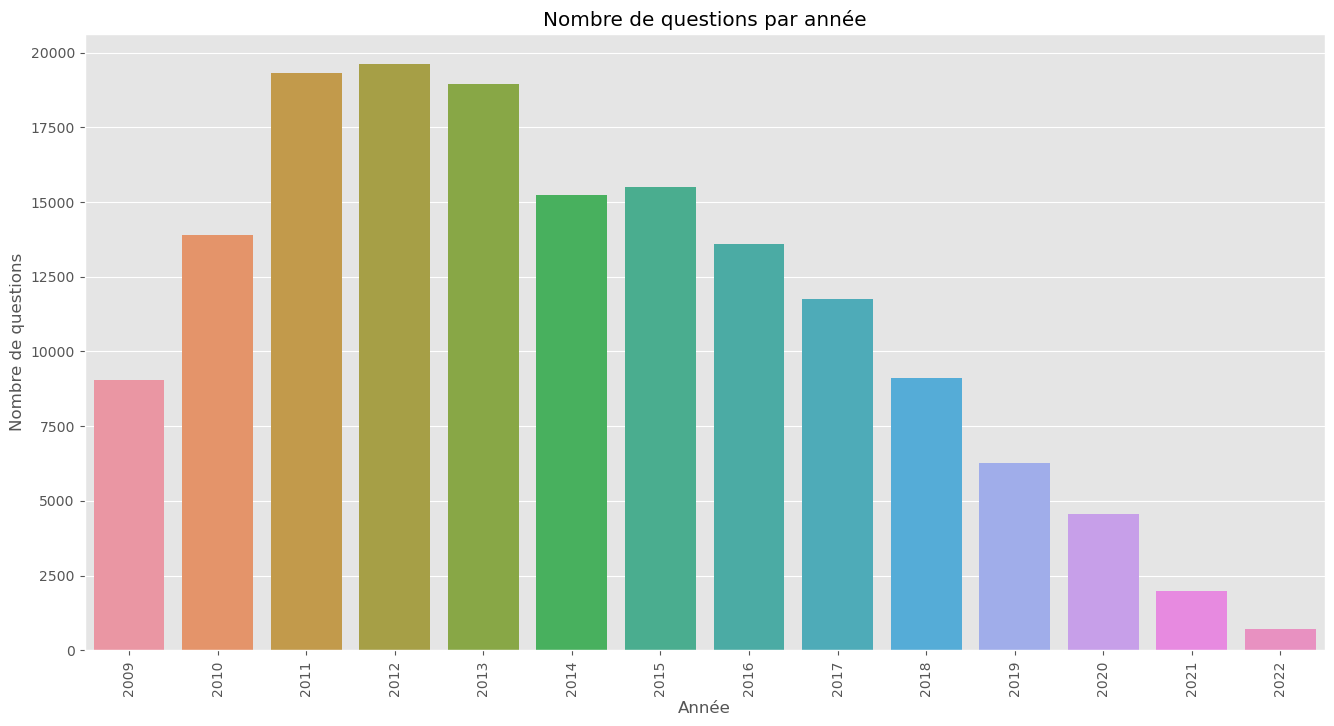

In [19]:
fig = plt.figure(figsize=(16, 8))
sns.barplot(x=questions_per_year.index, y=questions_per_year.values)
plt.title("Nombre de questions par année")
plt.xlabel("Année")
plt.xticks(rotation=90)
plt.ylabel("Nombre de questions")
plt.show()

In [20]:
data["CreationDate_month"] = data["CreationDate"].map(lambda m: m.month)

In [21]:
questions_per_month = data["CreationDate_month"].value_counts()

In [22]:
months = ["Janvier", "Fevrier", "Mars",
          "Avril", "Mai", "Juin",
          "Juillet", "Aout", "Septembre",
          "Octobre", "Novembre", "Decembre"]

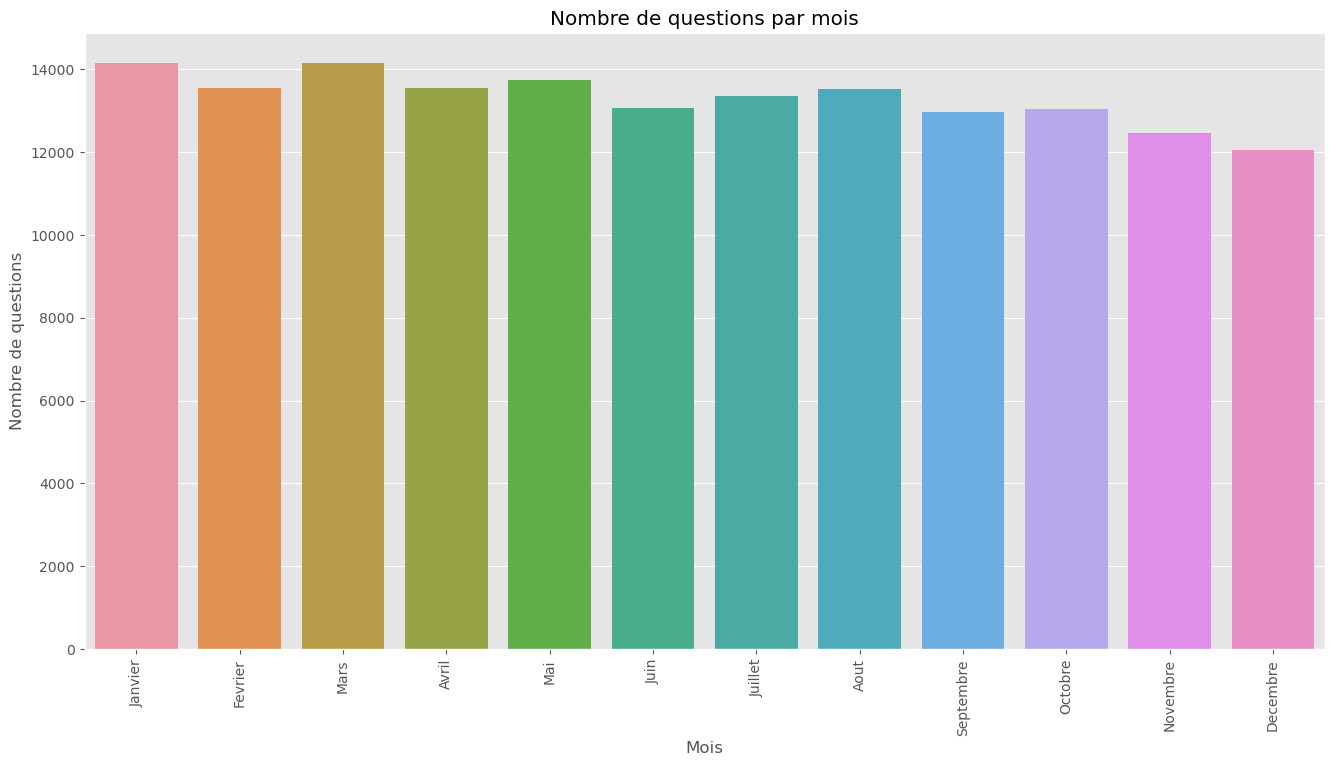

In [23]:
fig = plt.figure(figsize=(16, 8))
sns.barplot(x=questions_per_month.index, y=questions_per_month.values)
plt.title("Nombre de questions par mois")
plt.xlabel("Mois")
plt.xticks(np.arange(0, 12),months, rotation=90)
plt.ylabel("Nombre de questions")
plt.show()

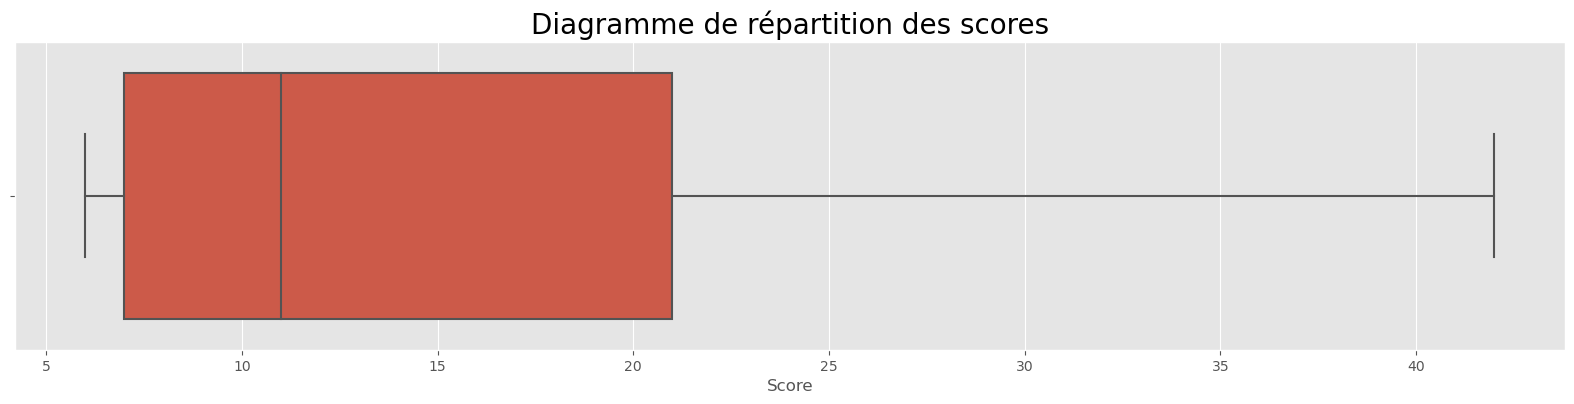

In [24]:
fig = plt.figure(figsize=(20, 4))
plt.title('Diagramme de répartition des scores',
          titleprops)
sns.boxplot(data=data, x="Score", showfliers=False)

plt.show()

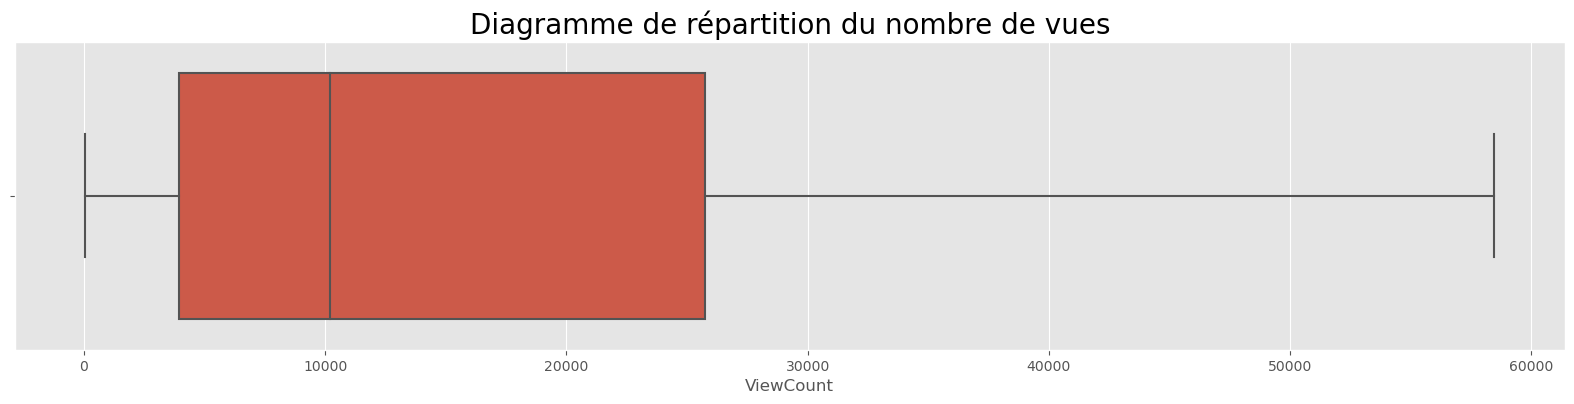

In [25]:
fig = plt.figure(figsize=(20, 4))
plt.title('Diagramme de répartition du nombre de vues',
          titleprops)
sns.boxplot(data=data, x="ViewCount", showfliers=False)

plt.show()

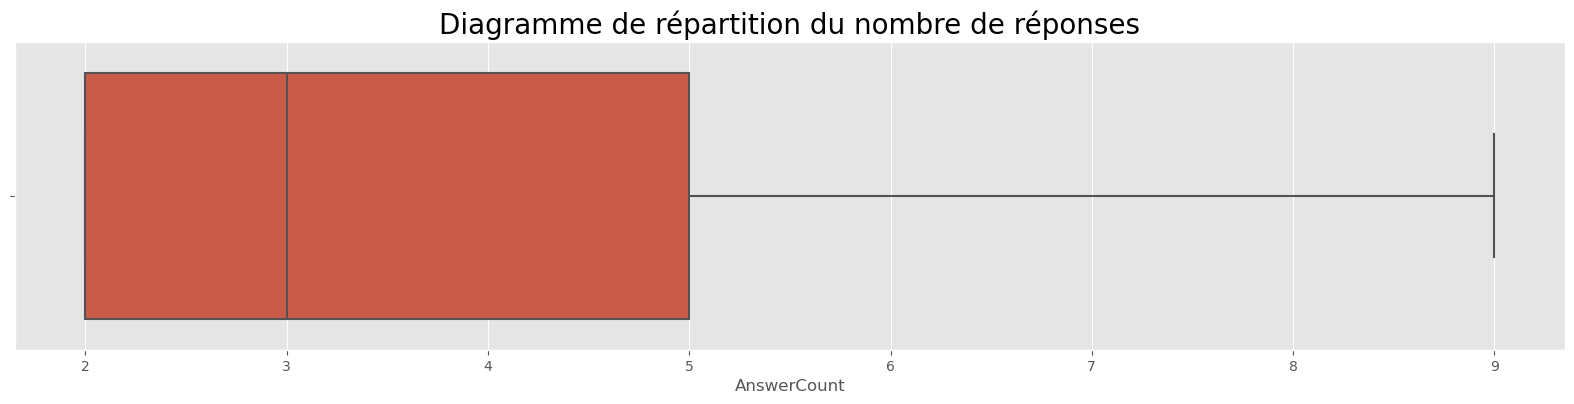

In [26]:
fig = plt.figure(figsize=(20, 4))
plt.title('Diagramme de répartition du nombre de réponses',
          titleprops)
sns.boxplot(data=data, x="AnswerCount", showfliers=False)

plt.show()

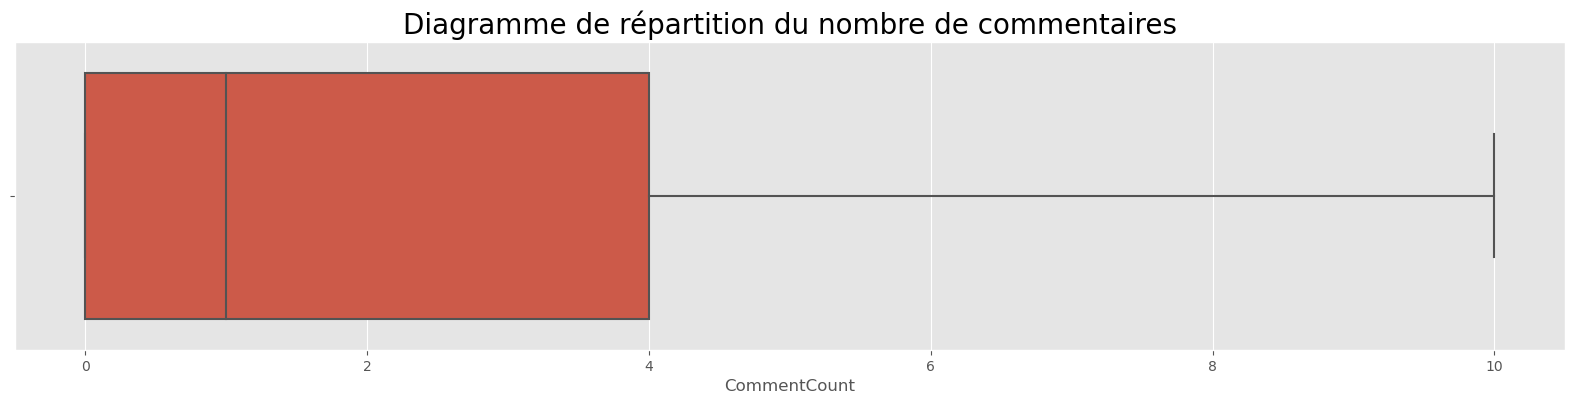

In [27]:
fig = plt.figure(figsize=(20, 4))
plt.title('Diagramme de répartition du nombre de commentaires',
          titleprops)
sns.boxplot(data=data, x="CommentCount", showfliers=False)

plt.show()

## <font color="#114b98" id="section_3">3. Analyse multivariée</font>

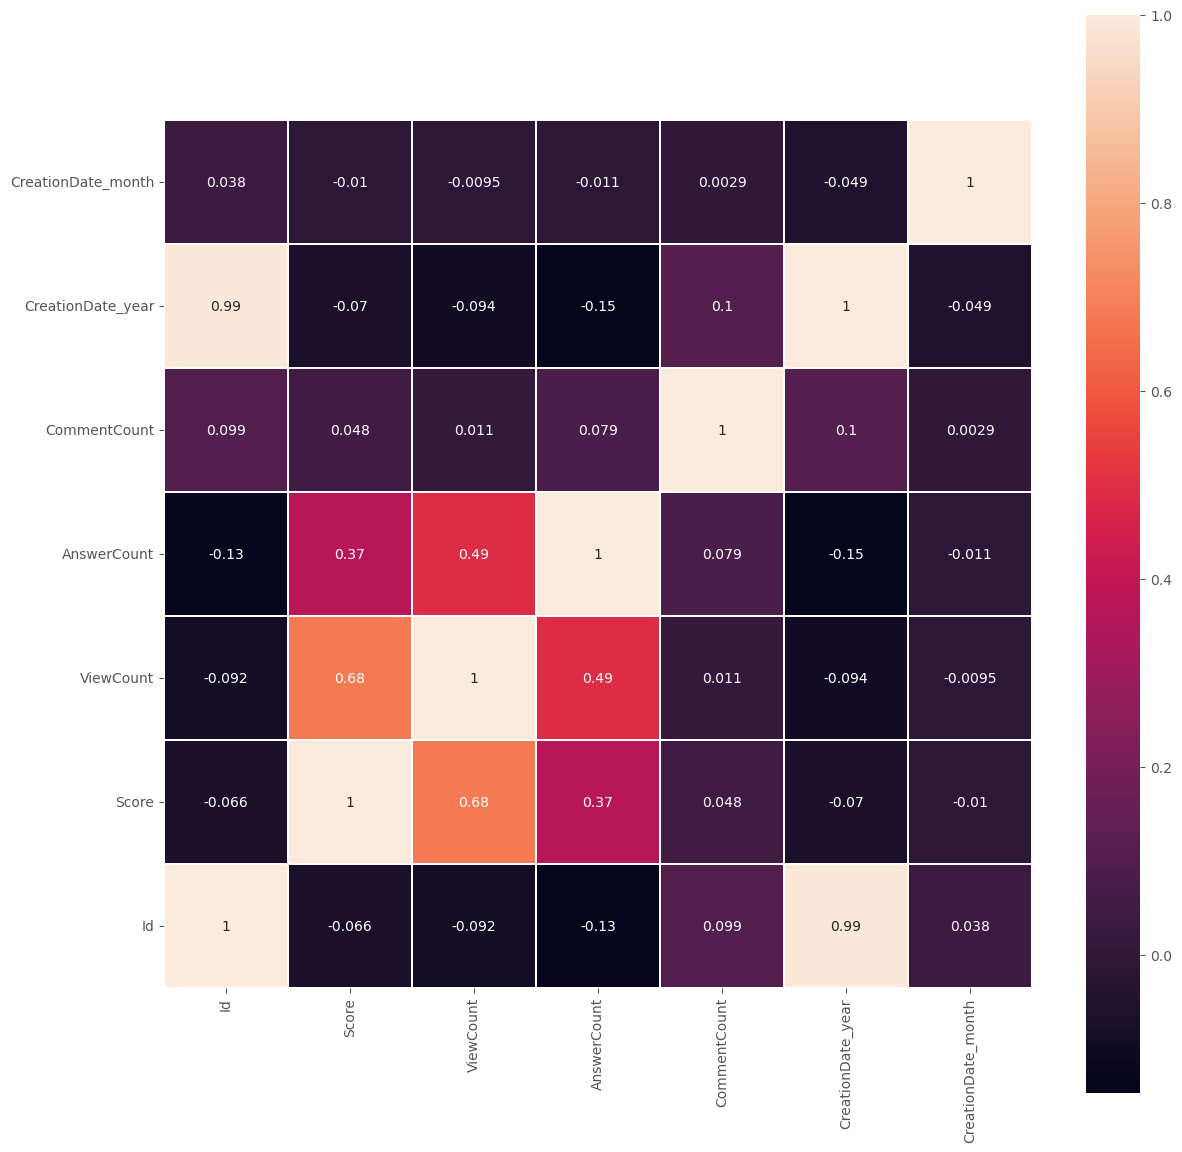

In [28]:
corr_matrix = data.corr()
fig = plt.figure(1, figsize=(14, 14))
sns.heatmap(corr_matrix, square=True, linewidths=0.1, annot=True)
plt.xlim(0, corr_matrix.shape[1])
plt.ylim(0, corr_matrix.shape[0])
plt.show()

La corrélation entre le nombre de vues et le score est normale.

Une question bien notée a davantage de chance d'être pertinente et qu'un grand nombre de personne la consulte.

In [29]:
data.columns

Index(['Id', 'CreationDate', 'Title', 'Body', 'Tags', 'Score', 'ViewCount',
       'AnswerCount', 'CommentCount', 'Texte', 'CreationDate_year',
       'CreationDate_month'],
      dtype='object')

In [30]:
data.drop(columns=['Id',
                   'CreationDate',
                   'Score',
                   'ViewCount',
                   'AnswerCount',
                   'CommentCount',
                   'CreationDate_year',
                   'CreationDate_month',
                   'Body',
                   'Title'],
          inplace=True)

In [31]:
data.shape

(159599, 2)

In [32]:
data.head()

,Tags,Texte
0,<macos><emacs><scheme><interpreter><sicp>,How do I get a scheme interpreter working insi...
1,<c#><functional-programming><delegates><lambda...,Scope of variables in a delegate <p>I found th...
2,<mysql><database><arrays><postgresql><stored-p...,"How can I pass an ""array"" of values to my stor..."
3,<ios><objective-c><iphone><cocoa-touch><uibutton>,Manually setting a UIButton state <p>I <code>U...
4,<database><nhibernate><exception-handling><con...,Should I check for DB constraints in code or s...


## <font color="#114b98" id="section_4">4. Nettoyage de la colonne 'Tags'</font>

In [33]:
data['Tags'][0:5]

0            <macos><emacs><scheme><interpreter><sicp>
1    <c#><functional-programming><delegates><lambda...
2    <mysql><database><arrays><postgresql><stored-p...
3    <ios><objective-c><iphone><cocoa-touch><uibutton>
4    <database><nhibernate><exception-handling><con...
Name: Tags, dtype: object

Les tags sont encadrés par des balises "<" et ">".

In [34]:
data['Tags'][0][1:-1].split('><')

['macos', 'emacs', 'scheme', 'interpreter', 'sicp']

In [35]:
data['Tags'] = data['Tags'].apply(lambda row: row[1:-1].split('><'))

In [36]:
tags = []
for minilist in data['Tags']:
    for item in minilist:
        item = item.lower()
        tags.append(item)

In [37]:
from collections import Counter

In [38]:
counts = Counter(tags)

In [39]:
temp_df = pd.DataFrame.from_dict(counts, orient='index', columns=['count'])
plot_df = temp_df.sort_values('count', ascending=False).head(20)

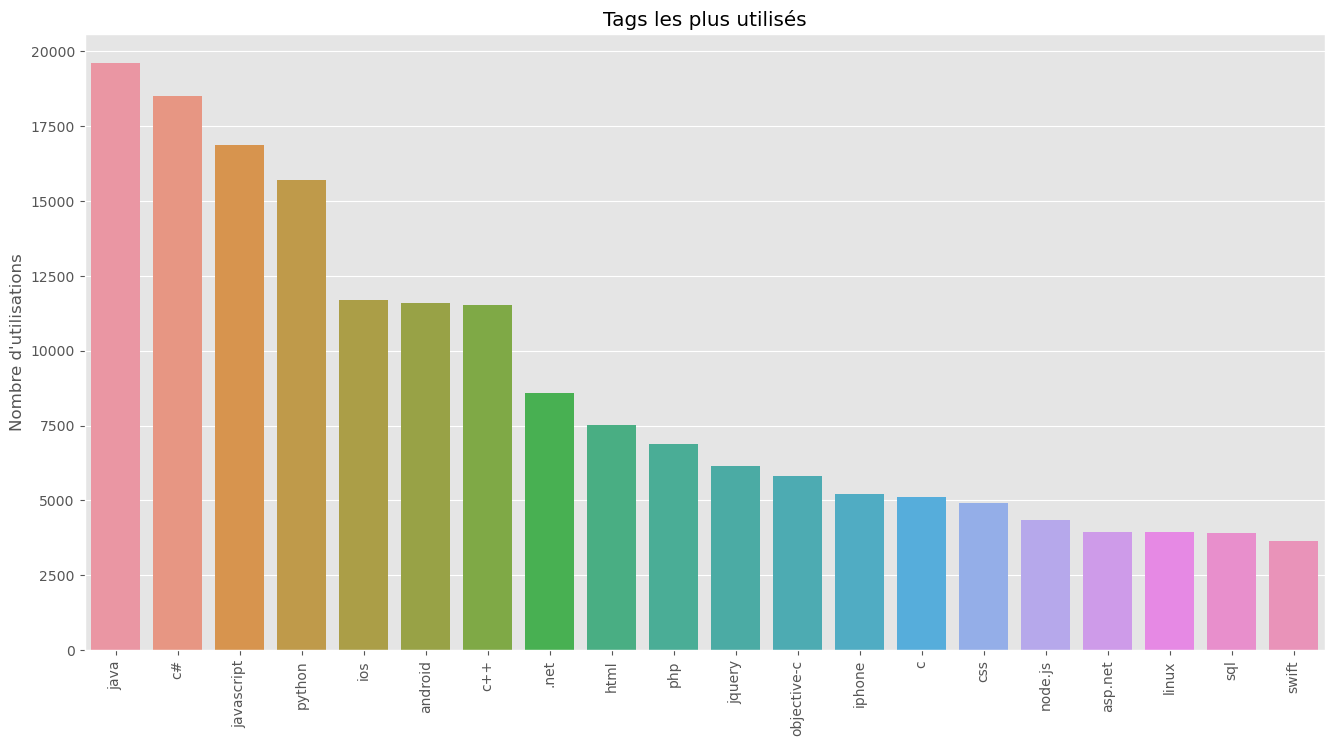

In [40]:
fig = plt.figure(figsize=(16, 8))
sns.barplot(x=plot_df.index, y=plot_df['count'])
plt.title("Tags les plus utilisés")
plt.xticks(rotation=90)
plt.ylabel("Nombre d'utilisations")
plt.show()

In [41]:
from wordcloud import WordCloud

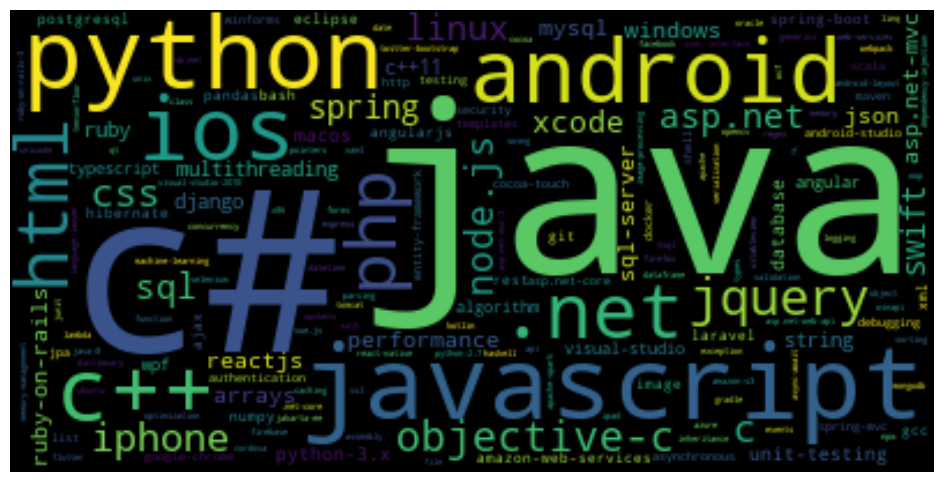

In [42]:
wordcloud = WordCloud().generate_from_frequencies(counts)
plt.figure(figsize=[14,6])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [43]:
data['Tags'].head()

0            [macos, emacs, scheme, interpreter, sicp]
1    [c#, functional-programming, delegates, lambda...
2    [mysql, database, arrays, postgresql, stored-p...
3    [ios, objective-c, iphone, cocoa-touch, uibutton]
4    [database, nhibernate, exception-handling, con...
Name: Tags, dtype: object

## <font color="#114b98" id="section_5">5. Nettoyage de la colonne 'Texte'</font>

In [44]:
print(f"Observations dans le corpus : {data.shape[0]}")

Observations dans le corpus : 159599


In [45]:
data['Texte'][0:5]

0    How do I get a scheme interpreter working insi...
1    Scope of variables in a delegate <p>I found th...
2    How can I pass an "array" of values to my stor...
3    Manually setting a UIButton state <p>I <code>U...
4    Should I check for DB constraints in code or s...
Name: Texte, dtype: object

In [46]:
display(data['Texte'][0])

"How do I get a scheme interpreter working inside Emacs? <p>I'm going through SICP and I'd like to have an interpreter analogous to the interactive Python interpreter to play around in while I'm watching the lectures and reading the book. Furthermore, I'd like this interpreter to run inside Emacs so I can jump back and forth between files of scheme code and the interactive interpreter and so forth.</p>\n\n<p>However, I'm fairly new to Emacs and have not as of yet been able to get this to work or find one clear set of instructions to use in getting it to work.</p>\n\n<p>It seems like I should be able to set it up so that <code>M-x run-scheme</code> will open up an interactive interpreter that at least sounds like exactly what I want, but at the moment this just returns <code>Searching for program: no such file or directory, scheme</code> and I haven't been able to figure out exactly what files I need to put where to remedy this.</p>\n\n<p>I'm running <code>GNU Emacs 22.1.1 (mac-apple-da

Je passe tout d'abord tous les textes en minuscule.

In [47]:
data['Texte'] = data['Texte'].str.lower()

Le texte comporte des balises HTML., je vais les supprimer à l'aide de BeautifulSoup.

In [48]:
import lxml
import html5lib
from bs4 import BeautifulSoup

In [49]:
def clean_html(text):
    soup = BeautifulSoup(text, "html5lib")
    for sent in soup(['style', 'script']):
        sent.decompose()
    return ' '.join(soup.stripped_strings)

In [50]:
clean_html(data['Texte'][0])

"how do i get a scheme interpreter working inside emacs? i'm going through sicp and i'd like to have an interpreter analogous to the interactive python interpreter to play around in while i'm watching the lectures and reading the book. furthermore, i'd like this interpreter to run inside emacs so i can jump back and forth between files of scheme code and the interactive interpreter and so forth. however, i'm fairly new to emacs and have not as of yet been able to get this to work or find one clear set of instructions to use in getting it to work. it seems like i should be able to set it up so that m-x run-scheme will open up an interactive interpreter that at least sounds like exactly what i want, but at the moment this just returns searching for program: no such file or directory, scheme and i haven't been able to figure out exactly what files i need to put where to remedy this. i'm running gnu emacs 22.1.1 (mac-apple-darwin, carbon version 1.6.0) as installed through the os x 10.5 in

In [51]:
data['Texte'] = data['Texte'].apply(clean_html)

In [52]:
data['Texte'][0]

"how do i get a scheme interpreter working inside emacs? i'm going through sicp and i'd like to have an interpreter analogous to the interactive python interpreter to play around in while i'm watching the lectures and reading the book. furthermore, i'd like this interpreter to run inside emacs so i can jump back and forth between files of scheme code and the interactive interpreter and so forth. however, i'm fairly new to emacs and have not as of yet been able to get this to work or find one clear set of instructions to use in getting it to work. it seems like i should be able to set it up so that m-x run-scheme will open up an interactive interpreter that at least sounds like exactly what i want, but at the moment this just returns searching for program: no such file or directory, scheme and i haven't been able to figure out exactly what files i need to put where to remedy this. i'm running gnu emacs 22.1.1 (mac-apple-darwin, carbon version 1.6.0) as installed through the os x 10.5 in

Je vais conserver uniquement les caractères alphabétiques et supprimer les mots de moins de trois lettres, même si cela va éliminer aussi des informations qui auraient été pertinentes (C, C++, C#, R, ...).

In [53]:
import re

In [54]:
def clean_text(text):
    pattern = re.compile(r'[^\w]|[\d_]')
    res = re.sub(pattern, " ", text)
    res = " ".join(word for word in res.split() if len(word) >= 3)
    return res

In [55]:
data['Texte'] = data['Texte'].apply(clean_text)

In [56]:
display(data['Texte'][0])

'how get scheme interpreter working inside emacs going through sicp and like have interpreter analogous the interactive python interpreter play around while watching the lectures and reading the book furthermore like this interpreter run inside emacs can jump back and forth between files scheme code and the interactive interpreter and forth however fairly new emacs and have not yet been able get this work find one clear set instructions use getting work seems like should able set that run scheme will open interactive interpreter that least sounds like exactly what want but the moment this just returns searching for program such file directory scheme and haven been able figure out exactly what files need put where remedy this running gnu emacs mac apple darwin carbon version installed through the install dvd'

Je vais maintenant tokeniser afin de transformer les textes en listes de termes distincts (token). 

J'élimine aussi les termes génériques anglais (stop words) afin de n'avoir que des mots pertinents.

In [57]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [58]:
def tokenize(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text, language='english')
    return [token for token in tokens if token not in stop_words]

In [59]:
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')

In [60]:
data['Texte'] = data['Texte'].apply(tokenize)

In [61]:
data['Texte'][0][0:5]

['get', 'scheme', 'interpreter', 'working', 'inside']

Les mots qui m'interessent le plus sont des noms. Je peux utiliser un modèle de POS tagging basé sur les chaînes de Markov.

In [62]:
from nltk import pos_tag
# nltk.download('averaged_perceptron_tagger')

In [63]:
def filtering_nouns(tokens):
    res = [token for token, tag in pos_tag(tokens) if tag == 'NN']
    return res

In [64]:
data['Texte'] = data['Texte'].apply(filtering_nouns)

In [65]:
data['Texte'][0][0:5]

['interpreter', 'emacs', 'interpreter', 'python', 'interpreter']

Je vais maintenant lemmatiser, c'est-à-dire identifier la racine sémantique (lemme) des termes et ne conserver que celle-ci afin de ne pas en avoir toutes les déclinaisons des mots.

In [66]:
from nltk.stem import WordNetLemmatizer

In [67]:
def lemmatization(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

In [68]:
data['Texte'] = data['Texte'].apply(filtering_nouns)

In [69]:
data['Texte'][0][0:5]

['interpreter', 'emacs', 'interpreter', 'python', 'interpreter']

In [70]:
print(f"Observations dans le corpus : {data.shape[0]}")

Observations dans le corpus : 159599


Je peux observer les fréquences de distribution des tokens.

In [71]:
from nltk import FreqDist

In [72]:
def build_word_distribution(corpus):

    word_dist = FreqDist(corpus)
    word_dist_df = pd.DataFrame(word_dist.items(), columns=['Word', 'Frequency']).set_index('Word')
    word_dist_df.sort_values("Frequency", ascending=False, inplace=True)

    return word_dist_df

In [73]:
data['Texte_f'] = data['Texte'].apply(build_word_distribution)

In [74]:
data['Texte_f'][0][0:5]

,Frequency
Word,
interpreter,5
work,2
program,1
version,1
carbon,1


In [75]:
data.head()

,Tags,Texte,Texte_f
0,"[macos, emacs, scheme, interpreter, sicp]","[interpreter, emacs, interpreter, python, inte...",Frequency Word ...
1,"[c#, functional-programming, delegates, lambda...","[scope, bug, compiler, voidfunction, delegate,...",Frequency Word ...
2,"[mysql, database, arrays, postgresql, stored-p...","[pass, array, procedure, pass, array, procedur...",Frequency Word proc...
3,"[ios, objective-c, iphone, cocoa-touch, uibutton]","[state, need, figure, button, state, documenta...",Frequency Word ...
4,"[database, nhibernate, exception-handling, con...","[check, application, column, name, constraint,...",Frequency Word ...


In [76]:
csv_to_save = data[['text_cleaned', 'tags_cleaned']]
csv_to_save.to_csv(main_path+'saved_ressources/'+"data_clean.csv", index=False)

KeyError: "None of [Index(['text_cleaned', 'tags_cleaned'], dtype='object')] are in the [columns]"